I have used the following methods.

* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation[2],
* The project took place using <b>Google TPU</b>,
* There are many missing images (96 images). I used only mask images and correspondent images,
* I used <b>SeparableConv2D</b> instead of Conv2D in U-Net architecture,
* Used tf.data for input pipeline,
* <b>Custom layers</b> for encoding and decoding,
* <b>Custom callback</b> for predicting one sample from test dataset during training each 20 epochs[3]

## Evaluation Results (for 100 epochs)


|                  | Train (562 images) | Test (141 images) |
|------------------|--------------------|-------------------|
| Loss             | 0.0612             | 0.0697            |
| Dice Loss        | 0.0627             | 0.0684            |
| Dice Coefficient | 0.9373             | 0.9316            |
| Jaccard Index    | 0.8619             | 0.8588            |


## Model Improvement During Training
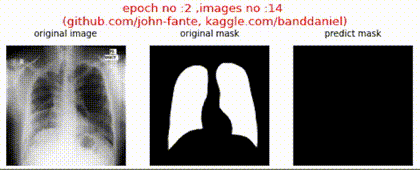

## Predictions
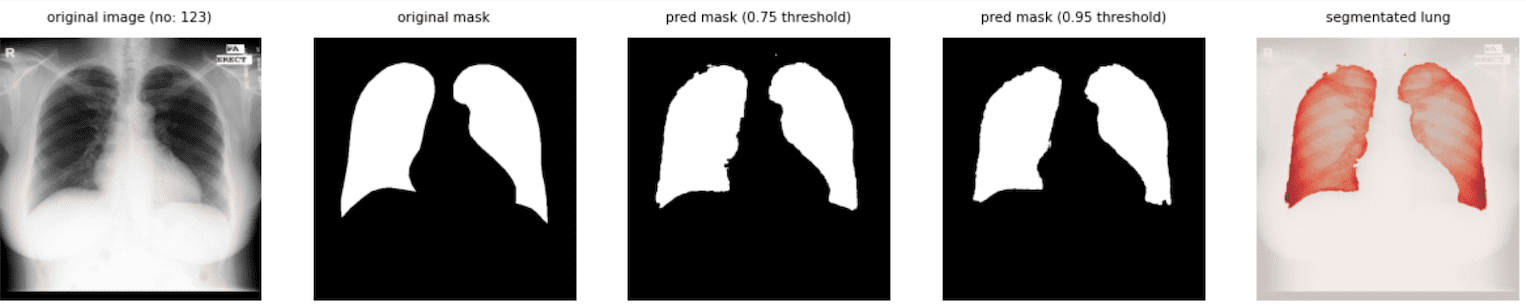

## My Another Segmentation Projects

* [Brain tumor/anomaly segmentation with Unet using TPU](https://github.com/john-fante/brain-tumor-segmentation-tpu)
* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice: 0.91, Jaccard: 0.82)](https://github.com/john-fante/eye-conjunctiva-segmentation)
* [Retina Vessel Segmentation w/TPU (Test Dice: 0.75)](https://www.kaggle.com/code/banddaniel/retina-vessel-segmentation-w-tpu-test-dice-0-75)
* [Brain tissue segmentation with Unet using TPU (Dice: 0.88)](https://github.com/john-fante/brain-tissue-segmentation-tpu)


## References
1. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation (Version 1). arXiv. https://doi.org/10.48550/ARXIV.1505.04597
2. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
3. My another custom callbacks for Tensorflow (https://github.com/john-fante/my-tensorflow-custom-callbacks)


In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Layer, concatenate , BatchNormalization

SEED = 10
BATCH_SIZE = 16
IMG_SIZE = 512, 512

D1001 15:51:03.052322636      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1001 15:51:03.052367954      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1001 15:51:03.052372947      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1001 15:51:03.052376031      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1001 15:51:03.052378737      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1001 15:51:03.052381754      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1001 15:51:03.052384422      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1001 15:51:03.

In [2]:
# Connecting TPU and creating strategy and the model

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
strategy = tf.distribute.TPUStrategy(tpu)

print('total tpu core : ' + str(strategy.num_replicas_in_sync))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [3]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


# There are many missing images (96 images). I used only mask images and correspondent images
def images_from_masks(base_path, images_path):
    full_path = []
    images = sorted(os.listdir(images_path))
    base_path = base_path + '/CXR_png'
    for i in images:
        if i[0] == 'C':
            full_path.append(os.path.join(base_path, i[:-9] + '.png'))
        elif i[0] == 'M':
            full_path.append(os.path.join(base_path, i[:-4] + '.png'))
    return full_path



masks = create_images_list('/kaggle/input/chest-xray-masks-and-labels-images/masks')
images = images_from_masks("/kaggle/input/chest-xray-masks-and-labels-images", '/kaggle/input/chest-xray-masks-and-labels-images/masks')

full_data = pd.DataFrame({'image': images, 'mask': masks })
full_data = shuffle(full_data, random_state = SEED).reset_index().drop( columns = ['index'], axis = 1)

# Splitting the train and the test sets
X_train, X_test, y_train, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.2)

In [4]:
print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  562
test images:  141


In [5]:
def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask

In [6]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (train_loader
                 .map(img_preprocessing)
                 .shuffle(X_train.shape[0])
                 .batch(BATCH_SIZE)
                 .prefetch(BATCH_SIZE))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing)
                .batch(BATCH_SIZE)
                .prefetch(BATCH_SIZE))

# <span style="color:#e74c3c;"> U-net </span> Model


In [7]:
# Encoding block for U-net architecture

class EncoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, pooling = True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.rate = rate
        self.pooling = pooling
        
        self.conv1 = SeparableConv2D(filters, kernel_size, activation = 'relu', strides = 1, padding='same', kernel_initializer = 'he_normal')
        self.conv2 = SeparableConv2D(filters, kernel_size, activation = 'relu', strides = 1, padding='same', kernel_initializer = 'he_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPooling2D()
        
    
    def call(self, inputs):
        X = self.conv1(inputs)
        X = self.drop(X)
        X = self.conv2(X)
        if self.pooling:
            P = self.pool(X)
            return P,X
        else:
            return X
    
    
    def get_config(self):
        base_config = super().get_config()
        
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }


In [8]:
# Decoding block for U-net architecture

class DecoderBlock(Layer):
    def __init__(self, filters, kernel_size, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.filters = filters 
        self.kernel_size = kernel_size
        self.rate = rate
        
        self.up = UpSampling2D()
        self.nn = EncoderBlock(filters, kernel_size, rate, pooling = False)
        
    def call(self, inputs):
        inputs, skip_inputs = inputs
        X = self.up(inputs)
        C = concatenate([X, skip_inputs])
        X = self.nn(C)
        return X
    
   
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "rate" : self.rate,
            "pooling" : self.pooling }

In [9]:
# Custom callback for predicting one sample from test dataset during training each 20 epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 20 == 0:
            samples = list(test_dataset.take(-1))
        
            idxs = np.random.permutation(y_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs
        
            image = samples[batch_idx][0][image_idx] 
            mask = samples[batch_idx][1][image_idx]
        
            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.5
            bitmap_pred = (pred_ > threshold).astype(np.uint8)
        
            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' 
                         + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)
                            
            plt.tight_layout()
            plt.show()
        else:
            pass

In [10]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    jac_idx = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-2 )
    
    return jac_idx

# <span style="color:#e74c3c;"> Training </span> 


In [11]:
# Creating model

with strategy.scope():
    inp = Input(shape = (*IMG_SIZE, 1))

    p1, c1 = EncoderBlock(32, 2, 0.1, name = 'Encoder1')(inp)
    p2, c2 = EncoderBlock(64, 2, 0.1, name = 'Encoder2')(p1)
    p3, c3 = EncoderBlock(128, 2, 0.2, name = 'Encoder3')(p2)
    p4, c4 = EncoderBlock(256, 2, 0.2, name = 'Encoder4')(p3)

    encoding = EncoderBlock(512 , 2, 0.3, pooling = False ,name = 'Encoding')(p4)

    d1 = DecoderBlock(256, 2, 0.2 ,name = 'Decoder1' )([encoding, c4])
    d2 = DecoderBlock(128 ,2, 0.2 ,name = 'Decoder2' )([d1, c3])
    d3 = DecoderBlock(64 ,2, 0.1 ,name = 'Decoder3' )([d2, c2])
    d4 = DecoderBlock(32 ,2, 0.1 ,name = 'Decoder4' )([d3, c1])

    out = Conv2D(1, kernel_size = 1 ,activation ='sigmoid', padding = 'same')(d4)
    model = Model(inputs = inp, outputs = out)

    model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = [dice_coef_loss, dice_coef, jaccard ])
    my_callbacks  = [PredictDuringTraining()]

Epoch 1/100


2023-10-01 15:51:30.139615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-01 15:51:30.389044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 37s 181ms/step - loss: 0.6676 - dice_coef_loss: 0.6597 - dice_coef: 0.3403 - jaccard: 0.1914
Epoch 2/100
36/36 [==============================] - 9s 179ms/step - loss: 0.5767 - dice_coef_loss: 0.7162 - dice_coef: 0.2838 - jaccard: 0.1524
Epoch 3/100
36/36 [==============================] - 9s 181ms/step - loss: 0.5488 - dice_coef_loss: 0.7282 - dice_coef: 0.2718 - jaccard: 0.1441
Epoch 4/100
36/36 [==============================] - 9s 180ms/step - loss: 0.5204 - dice_coef_loss: 0.7123 - dice_coef: 0.2877 - jaccard: 0.1547
Epoch 5/100
36/36 [==============================] - 9s 179ms/step - loss: 0.4516 - dice_coef_loss: 0.6337 - dice_coef: 0.3663 - jaccard: 0.2111
Epoch 6/100
36/36 [==============================] - 9s 180ms/step - loss: 0.4051 - dice_coef_loss: 0.5347 - dice_coef: 0.4653 - jaccard: 0.2884
Epoch 7/100
36/36 [==============================] - 9s 179ms/step - loss: 0.4017 - dice_coef_loss: 0.5206 - dice_coef: 0.4794 - jaccard: 0.3

2023-10-01 15:54:58.495384: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-01 15:54:58.580518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


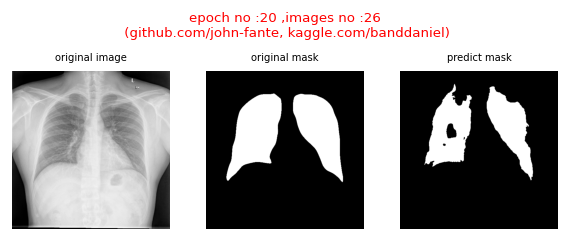

36/36 [==============================] - 17s 434ms/step - loss: 0.1797 - dice_coef_loss: 0.2033 - dice_coef: 0.7967 - jaccard: 0.6450
Epoch 21/100
36/36 [==============================] - 9s 177ms/step - loss: 0.1641 - dice_coef_loss: 0.1843 - dice_coef: 0.8157 - jaccard: 0.6718
Epoch 22/100
36/36 [==============================] - 9s 177ms/step - loss: 0.1568 - dice_coef_loss: 0.1750 - dice_coef: 0.8250 - jaccard: 0.6843
Epoch 23/100
36/36 [==============================] - 9s 178ms/step - loss: 0.1467 - dice_coef_loss: 0.1643 - dice_coef: 0.8357 - jaccard: 0.6998
Epoch 24/100
36/36 [==============================] - 9s 180ms/step - loss: 0.1424 - dice_coef_loss: 0.1581 - dice_coef: 0.8419 - jaccard: 0.7091
Epoch 25/100
36/36 [==============================] - 9s 178ms/step - loss: 0.1327 - dice_coef_loss: 0.1477 - dice_coef: 0.8523 - jaccard: 0.7248
Epoch 26/100
36/36 [==============================] - 8s 179ms/step - loss: 0.1372 - dice_coef_loss: 0.1525 - dice_coef: 0.8475 - jaccar

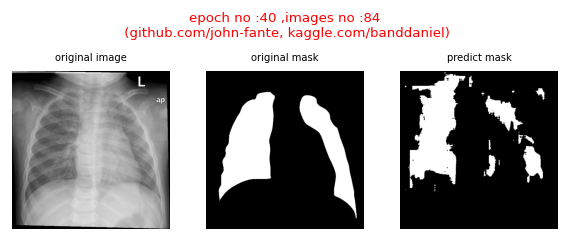

36/36 [==============================] - 11s 238ms/step - loss: 0.0965 - dice_coef_loss: 0.1076 - dice_coef: 0.8924 - jaccard: 0.7866
Epoch 41/100
36/36 [==============================] - 8s 178ms/step - loss: 0.0951 - dice_coef_loss: 0.1054 - dice_coef: 0.8946 - jaccard: 0.7901
Epoch 42/100
36/36 [==============================] - 8s 178ms/step - loss: 0.0966 - dice_coef_loss: 0.1091 - dice_coef: 0.8909 - jaccard: 0.7842
Epoch 43/100
36/36 [==============================] - 9s 177ms/step - loss: 0.0922 - dice_coef_loss: 0.1017 - dice_coef: 0.8983 - jaccard: 0.7960
Epoch 44/100
36/36 [==============================] - 8s 179ms/step - loss: 0.0898 - dice_coef_loss: 0.1004 - dice_coef: 0.8996 - jaccard: 0.7983
Epoch 45/100
36/36 [==============================] - 8s 178ms/step - loss: 0.0925 - dice_coef_loss: 0.1039 - dice_coef: 0.8961 - jaccard: 0.7924
Epoch 46/100
36/36 [==============================] - 8s 178ms/step - loss: 0.0883 - dice_coef_loss: 0.0990 - dice_coef: 0.9010 - jaccar

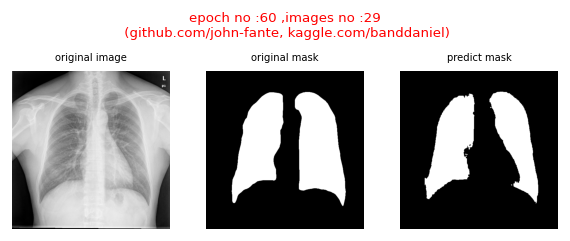

36/36 [==============================] - 11s 235ms/step - loss: 0.0728 - dice_coef_loss: 0.0819 - dice_coef: 0.9181 - jaccard: 0.8288
Epoch 61/100
36/36 [==============================] - 8s 178ms/step - loss: 0.0719 - dice_coef_loss: 0.0813 - dice_coef: 0.9187 - jaccard: 0.8300
Epoch 62/100
36/36 [==============================] - 9s 177ms/step - loss: 0.0721 - dice_coef_loss: 0.0812 - dice_coef: 0.9188 - jaccard: 0.8301
Epoch 63/100
36/36 [==============================] - 8s 177ms/step - loss: 0.0728 - dice_coef_loss: 0.0820 - dice_coef: 0.9180 - jaccard: 0.8288
Epoch 64/100
36/36 [==============================] - 9s 178ms/step - loss: 0.0718 - dice_coef_loss: 0.0805 - dice_coef: 0.9195 - jaccard: 0.8315
Epoch 65/100
36/36 [==============================] - 9s 179ms/step - loss: 0.0724 - dice_coef_loss: 0.0817 - dice_coef: 0.9183 - jaccard: 0.8291
Epoch 66/100
36/36 [==============================] - 9s 179ms/step - loss: 0.0711 - dice_coef_loss: 0.0800 - dice_coef: 0.9200 - jaccar

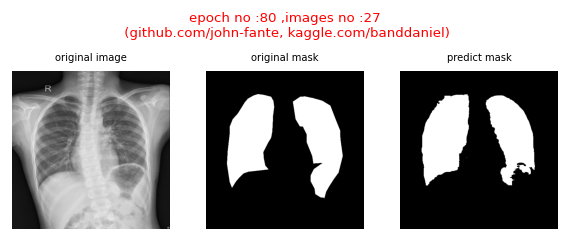

36/36 [==============================] - 11s 240ms/step - loss: 0.0624 - dice_coef_loss: 0.0710 - dice_coef: 0.9290 - jaccard: 0.8472
Epoch 81/100
36/36 [==============================] - 9s 178ms/step - loss: 0.0620 - dice_coef_loss: 0.0704 - dice_coef: 0.9296 - jaccard: 0.8484
Epoch 82/100
36/36 [==============================] - 9s 181ms/step - loss: 0.0617 - dice_coef_loss: 0.0695 - dice_coef: 0.9305 - jaccard: 0.8499
Epoch 83/100
36/36 [==============================] - 9s 178ms/step - loss: 0.0613 - dice_coef_loss: 0.0701 - dice_coef: 0.9299 - jaccard: 0.8490
Epoch 84/100
36/36 [==============================] - 8s 179ms/step - loss: 0.0602 - dice_coef_loss: 0.0682 - dice_coef: 0.9318 - jaccard: 0.8522
Epoch 85/100
36/36 [==============================] - 9s 179ms/step - loss: 0.0602 - dice_coef_loss: 0.0689 - dice_coef: 0.9311 - jaccard: 0.8510
Epoch 86/100
36/36 [==============================] - 8s 180ms/step - loss: 0.0590 - dice_coef_loss: 0.0668 - dice_coef: 0.9332 - jaccar

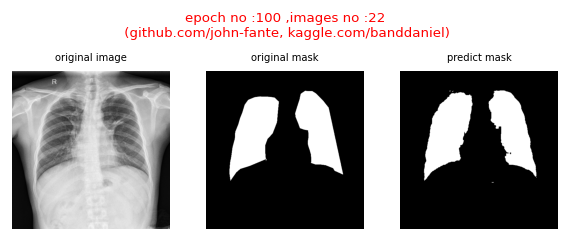

36/36 [==============================] - 11s 234ms/step - loss: 0.0554 - dice_coef_loss: 0.0635 - dice_coef: 0.9365 - jaccard: 0.8603


In [12]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE,epochs = 100 , callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation


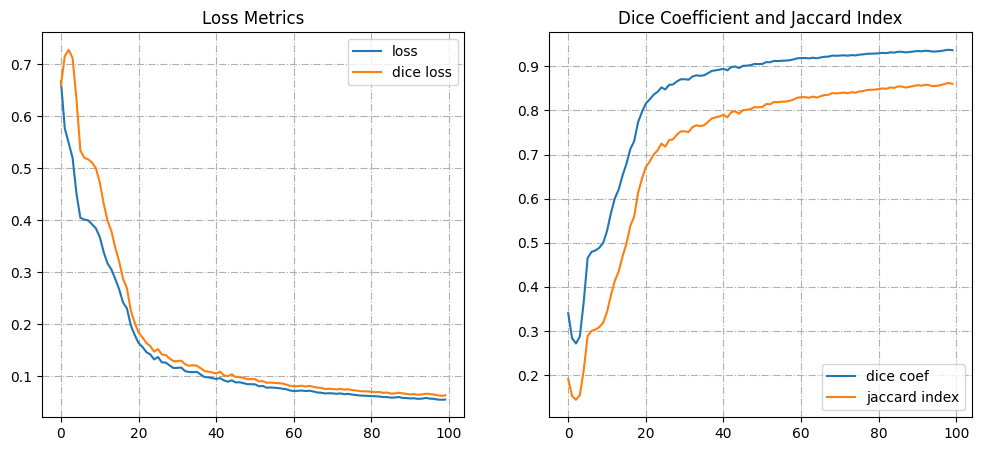

In [13]:
fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss Metrics")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['dice_coef_loss'])
axs[0].legend(["loss", "dice loss"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient and Jaccard Index")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['jaccard'])
axs[1].legend(['dice coef', 'jaccard index'])

In [14]:
train_eval = model.evaluate(train_dataset)

print('Train Loss : {0:.4f}'.format(train_eval[0]))
print('Train Dice Loss : {0:.4f}'.format(train_eval[1]))
print('Train Dice Coefficient : {0:.4f}'.format(train_eval[2]))
print('Train Jaccard Index : {0:.4f}'.format(train_eval[3]))

2023-10-01 16:07:30.328913: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-01 16:07:30.457688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 14s 88ms/step - loss: 0.0561 - dice_coef_loss: 0.0613 - dice_coef: 0.9387 - jaccard: 0.8644
Train Loss : 0.0561
Train Dice Loss : 0.0613
Train Dice Coefficient : 0.9387
Train Jaccard Index : 0.8644


# <span style="color:#e74c3c;"> Test </span> Prediction, Evaluation


In [15]:
test_eval = model.evaluate(test_dataset)

print('Test Loss : {0:.4f}'.format(test_eval[0]))
print('Test Dice Loss : {0:.4f}'.format(test_eval[1]))
print('Test Dice Coefficient : {0:.4f}'.format(test_eval[2]))
print('Test Jaccard Index : {0:.4f}'.format(test_eval[3]))

9/9 [==============================] - 2s 116ms/step - loss: 0.0787 - dice_coef_loss: 0.0683 - dice_coef: 0.9317 - jaccard: 0.8593
Test Loss : 0.0787
Test Dice Loss : 0.0683
Test Dice Coefficient : 0.9317
Test Jaccard Index : 0.8593


In [16]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.75 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.95 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

2023-10-01 16:07:48.184099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-01 16:07:48.296924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


9/9 [==============================] - 11s 289ms/step


In [17]:
# A function that creating one random image in the test set and prediction it

def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   

    fig, axs = plt.subplots(3,5, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]

        segmented = np.squeeze(test_take1_[batch_idx[i]][0][image_idx[i]] ) * pred_mask_1
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 5)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 5)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.75 threshold)', fontsize = 5)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.95 threshold)', fontsize = 5)
        
        axs[i][4].imshow(image , cmap ='gray')
        axs[i][4].imshow(segmented , alpha=0.2,  cmap ='gray')
        axs[i][4].imshow(segmented , alpha=0.8,  cmap ='Reds')
        axs[i][4].axis('off')
        axs[i][4].set_title('segmentated lung', fontsize = 5)

# <span style="color:#e74c3c;"> Test </span> Predictions


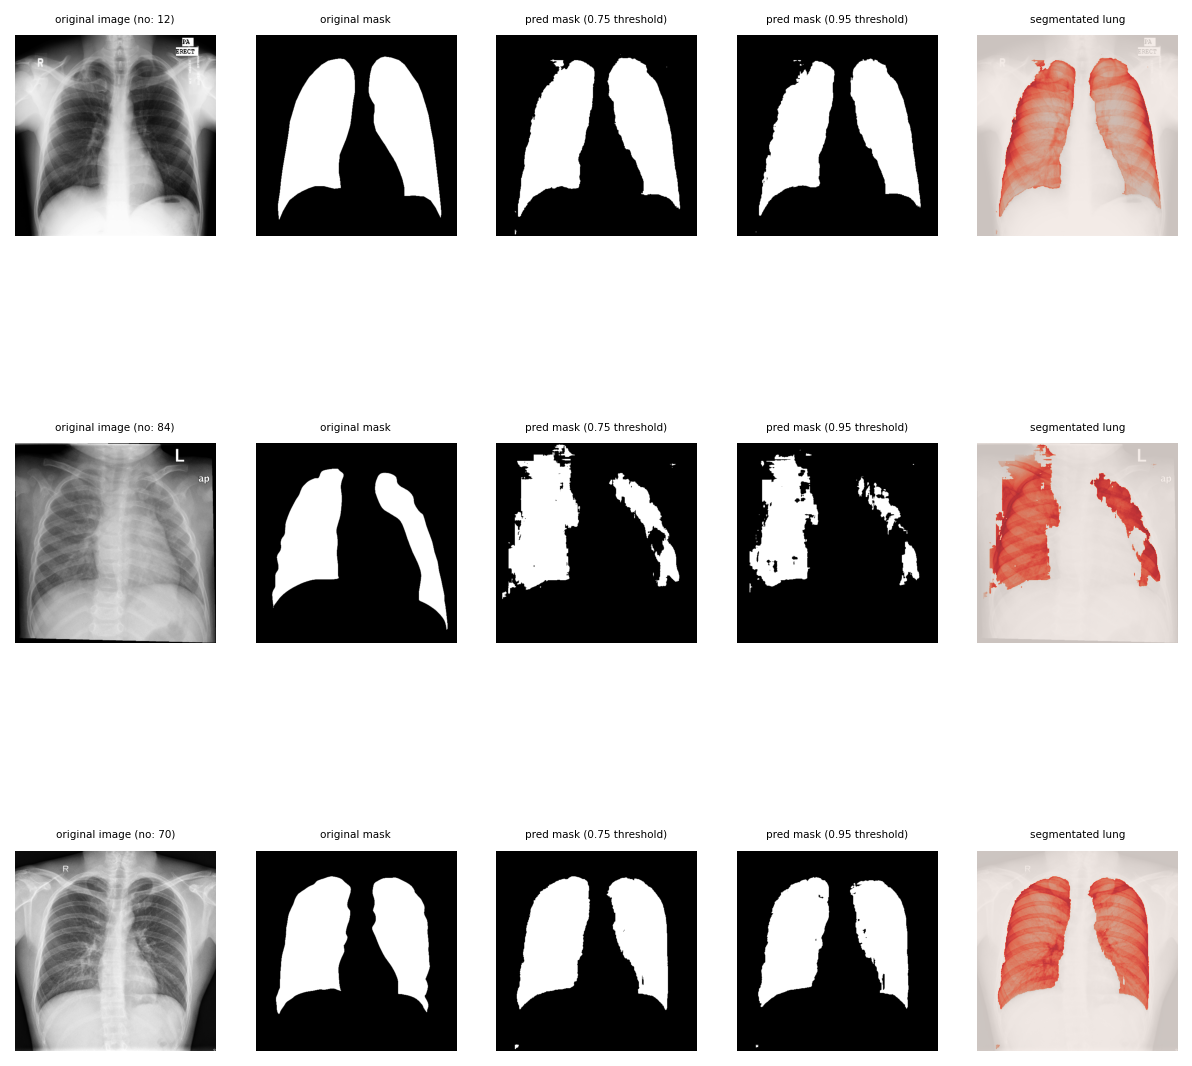

In [18]:
random_test_sample_with_prediction()